# **Task \#4 A**: Machine Learning MC886/MO444
##**Convolution Models and Transfer Learning**##

In [1]:
print('Tobias Conran Zorzetto' + ' RA: 166214')
print('Victor Costa Dominguite' + ' RA: 245003')

Tobias Conran Zorzetto RA: 166214
Victor Costa Dominguite RA: 245003


## Objective:

The objective of this project is to implement alternative approaches to **Convolutional Neural Networks** (CNNs) and **Transfer Learning Techniques** in order to devise the most effective model for addressing the given problems.

**Obs: In this work, you can use scikit-learn and PyTorch.**

## Dataset

The COCO (Common Objects in Context) dataset is a widely used benchmark dataset in computer vision research. It serves as a valuable resource for various tasks including object recognition, segmentation, and captioning. The dataset comprises a vast collection of images, each meticulously annotated with detailed information about the objects present in the image. It covers a diverse range of object categories, encompassing everyday objects such as people, animals, vehicles, and household items.

Dataset Information:

- The dataset consists of approximately 115,000 images. However, for your convenience, you can work with a subset that contains at least 30,000 images. You can utilize the function get_partial_dataset to create this partial dataset.

- The following code cell will download the dataset, but please note that if the runtime gets disconnected, you will need to download it again. In case the authorization key doesn't work, you can download the dataset from the links provided below.

- The data is available at: ([Link of the Dataset](https://drive.google.com/drive/folders/12dZ4lkKkAZ6CKcvDtwzXSLrYOy_avWW8?usp=sharing)): ```Multiclass Classfication``` and ```COCO JSON```


More information about the dataset: *Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." Computer Vision–ECCV 2014: 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V 13. Springer International Publishing, 2014.*

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%%time
!tar -xf drive/MyDrive/COCO-Dataset/coco-multiclass.tar.gz
#!tar -xf drive/MyDrive/COCO-Dataset/coco-object-detection.tar.gz

CPU times: user 710 ms, sys: 81.1 ms, total: 791 ms
Wall time: 2min 3s


## Libraries

In [4]:
import os
import cv2
import json
import torch
import numpy as np
import glob as glob
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from torchvision import models
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import Resize, Compose, ToTensor, ColorJitter, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Dataset, DataLoader

import copy
import torch.optim as optim
import torch.nn.functional as F

## Classification Task with COCO

In the COCO dataset, each sample can have multiple labels. Therefore, using the CrossEntropy loss function, which relies on softmax activation, is not suitable for the multi-label classification problem. Let's explore why CrossEntropy is not appropriate in this case.

![loss_definition_1](https://drive.google.com/uc?export=view&id=1BDkR2n6aNq6VvXnQNYw7dxtzfveijysB)

The above image illustrates how we calculate the CrossEntropy loss in a simple multi-class classification scenario, where the target labels are mutually exclusive. The loss computation focuses on the logit corresponding to the true target label and its relative magnitude compared to other labels. However, softmax ensures that all predicted probabilities sum to 1, making it impossible to have several correct answers.

![loss_definition_2](https://drive.google.com/uc?export=view&id=1tMQ0WFY1HAIlBnp3bSVic4gy1GJuJyc4)

To address this, we need to treat each prediction independently. One solution is to use the Sigmoid function as a normalizer for each logit value individually. This way, we can have multiple correct labels and their respective predicted probabilities for each label. We can then compare these probabilities with the probabilities of the correct labels (set to 1) using the BinaryCrossEntropy loss.

![loss_definition_3](https://drive.google.com/uc?export=view&id=1Mp5lo3EFEM7vMNE_5TM-Zts1NgY8oTrn)

Hence, the appropriate solution is to use the BinaryCrossEntropy loss.

**Consequently, models should have sigmoid as the last activation function to handle multi-label classification tasks correctly.**

In [5]:
## ----- Global Variables ----- ##
batch_size      = 64
learning_rate   = 0.01
epochs          = 3
evaluate_period = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Auxiliar functions


In [6]:
def get_partial_dataset(path, save_filename='partial_dataset', n_samples=30000):
  '''
    Creates a partial dataset for training

    Parameters
    ----------
    path : str
      Path to the _classes.csv file.

    save_filename : str
      Name of the file to be saved.

    n_samples : int
      Specifies the number of samples for training.
  '''

  df = pd.read_csv(path)
  idxs = []

  # --- Remove samples without class labels --- #
  for i, row in df.iterrows():
      if row[1:].sum() == 0:
          idxs.append(i)

  df.drop(idxs, inplace=True)

  # --- Randomly remove samples --- #
  idxs = df.sample(df.shape[0] - n_samples).index
  df = df.drop(idxs).reset_index(drop=True)

  print(f"Number of images used: {len(df)}")

  # --- Save locally --- #
  # Include the Google Drive path to ensure the preservation of this information!
  df.to_csv(f'{save_filename}.csv', index=False)

get_partial_dataset('COCO-multiclass/train/full_dataset.csv')

Number of images used: 30000


### Class Dataset and DataLoader

*Obs: Learn more in [Dataset and Dataloader Tutorial Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)*

In [7]:
class COCOMulticlass(Dataset):
  '''
    Dataset class

    Parameters:
    -----------
    __init__():
      annotations_file : str
        Path to the _classes.csv file or partial_dataset.csv file

      img_dir : str
        Path to the directory containing the images

      transform : torchvision.transforms
        Image transformations from the torchvision library.
  '''

  def __init__(self, annotations_file, img_dir, transform=None):
      self.img_labels = pd.read_csv(annotations_file)
      self.img_dir    = img_dir
      self.transform  = transform
      self.classes_names = self.img_labels.columns[1:]

  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
      image    = Image.open(img_path)
      label    = torch.Tensor(self.img_labels.iloc[idx, 1:].values.astype(float))

      if self.transform:
          image = self.transform(image)

      return image, label

In [46]:
# --- Image transformations --- #
data_transform = Compose([Resize((224,224)), ToTensor()])

# --- Datasets --- #
train_dataset = COCOMulticlass('partial_dataset.csv', 'COCO-multiclass/train', transform=data_transform)
valid_dataset = COCOMulticlass('COCO-multiclass/valid/_classes.csv', 'COCO-multiclass/valid', transform=data_transform)

# --- DataLoaders --- #
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# --- Classes --- #
class_names = train_dataset.classes_names

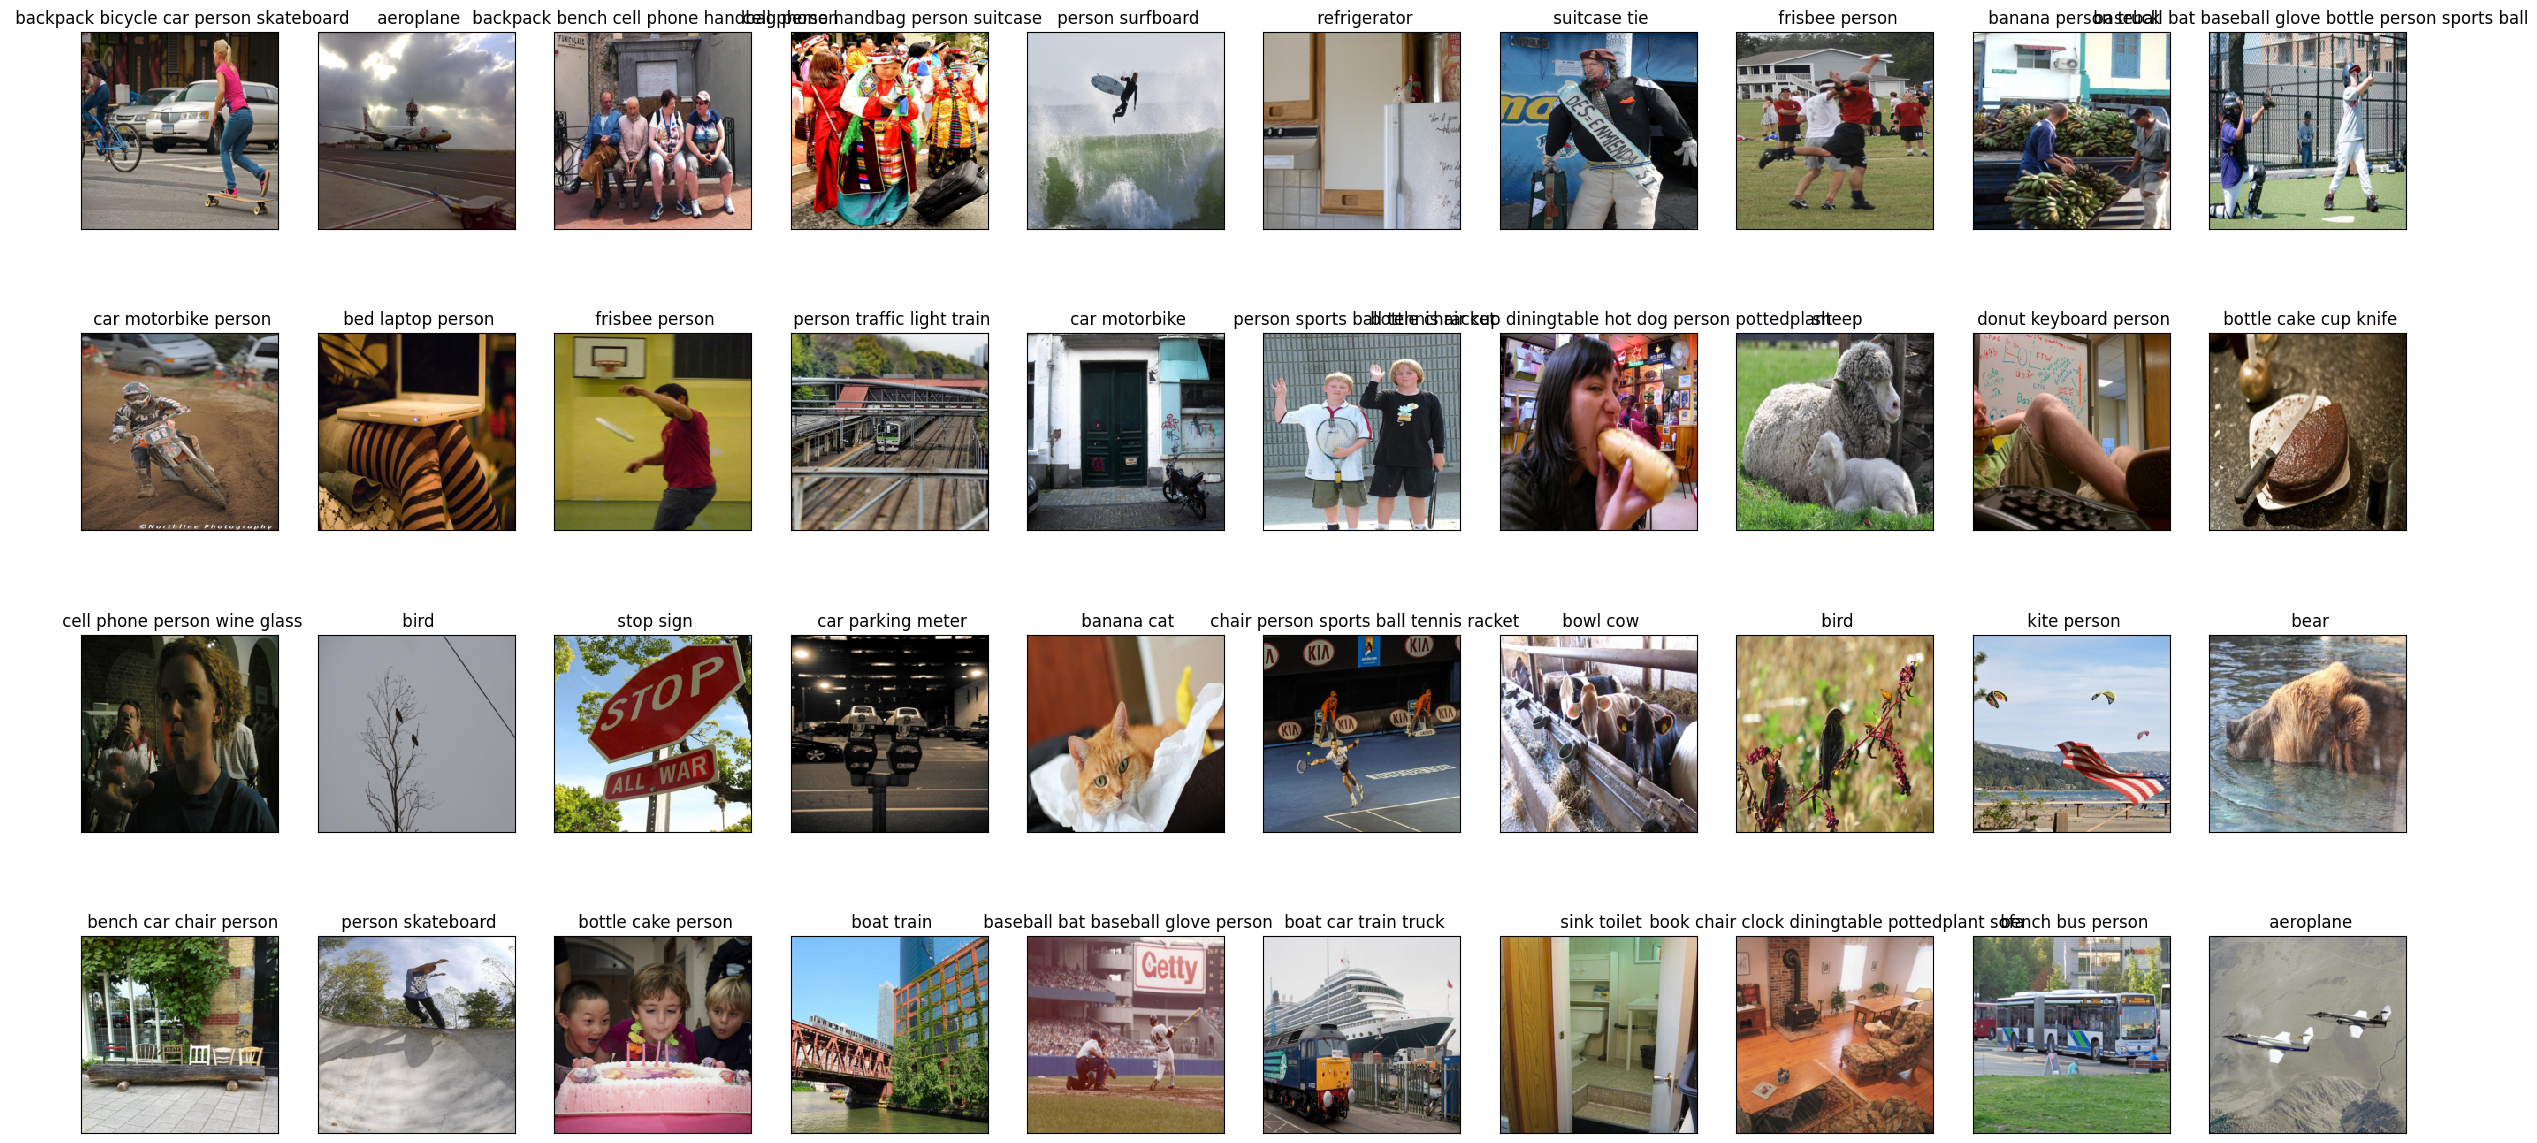

In [9]:
## ------ Plot Data ----- ##
fig, axes = plt.subplots(4, 10, figsize=(30,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    data, target = train_dataset.__getitem__(i*10)
    ax.imshow(data.permute(1,2,0), cmap='binary', interpolation='nearest')
    ax.set_title(''.join(class_names[target == 1]))

### Train and Evaluate functions

In [19]:
def train_one_epoch(model, criterion, optimizer, history):
  '''
    Simple training function.

    Parameters:
    -----------

    model : torch.nn.Module
      Modelo a ser treinado
    criterion : torch.nn
      Loss a ser utilizada para otimização dos pesos
    optimizer : torch.optim
      Otimizador para atualizar os pesos
  '''
  model.train()
  running_loss = 0.0
  trained = 0
  ## Interação entre os batchs
  for inputs, labels in train_loader:

    inputs, labels = inputs.to(device), labels.to(device)

    ## Zera os parâmetros do gradiente
    optimizer.zero_grad()

    ## Forward
    with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        ## Backward + Otimização apenas no conjunto de treino
        loss.backward()
        optimizer.step()

    ## Estatísticas
    running_loss += loss.item()

    trained += batch_size
    if trained % 10000 < batch_size:
      print(f"Trained: {trained-trained % 10000}/30000")
    inputs = inputs.to(device)
    labels = labels.to(device)

  epoch_loss = running_loss / len(train_loader.dataset)

  ## Histórico
  history['train']['loss'].append(epoch_loss)

  return model, history


def evaluate_one_epoch(model, criterion, optimizer, history):
  '''
    Simple evaluation function.

    Parameters:
    -----------

    model : torch.nn.Module
      Modelo a ser treinado
    criterion : torch.nn
      Loss a ser utilizada para otimização dos pesos
    optimizer : torch.optim
      Otimizador para atualizar os pesos
  '''
  data, target = next(iter(valid_loader))
  data = data.to(device)
  logits = model(data.type(torch.float))

  metrics = calculate_metrics(target, logits)

  model.eval()

  running_loss = 0.0

  ## Interação entre os batchs
  for inputs, labels in valid_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    ## Zera os parâmetros do gradiente
    optimizer.zero_grad()

    ## Forward
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

    ## Estatísticas
    running_loss += loss.item() * inputs.size(0)
  epoch_loss = running_loss / len(valid_loader.dataset)

  ## Histórico
  history['valid']['loss'].append(epoch_loss)
  history['valid']['acc'].append(metrics['acc'])
  history['valid']['precision'].append(metrics['precision'])
  history['valid']['recall'].append(metrics['recall'])

  return history, metrics

def save_model(model, best_loss, current_loss, save_path='weights.pth'):
  '''
    Save the best model weights.
    This function saves the weights locally.
    To prevent data loss, consider adding the Google Drive path in the `torch.save()` function.

    Parameters:
    -----------
    model : nn.Module
      Model to save the weights.

    best_loss : float
      Best loss achieved so far.

    current_loss : float
      Current loss to compare with the best loss.
  '''
  if best_loss == None:
    best_loss = current_loss
    torch.save(model.state_dict(), save_path)

  elif best_loss > current_loss:
    best_loss = current_loss
    torch.save(model.state_dict(), save_path)

  else: pass
  return best_loss

def load_model(path, model):
  '''
    Load the model weights.

    Parameters:
    -----------
    path : str
      Path to the .pth file containing the weights.

    model : nn.Module
      Model to load the weights into.
  '''
  model.load_state_dict(torch.load(path))
  return model

In [11]:
def calculate_metrics(target, pred, threshold=0.12):
    pred = np.array(pred.cpu() > threshold, dtype=float)
    corrects = 0
    accuracy = np.array([])
    true_positives = np.array([])
    false_positives = np.array([])
    false_negatives = np.array([])
    for i in range(len(pred)):
      equals = (np.where(pred[i] == np.array(target[i])))[0]
      diffs = (np.where(pred[i] != np.array(target[i])))[0]
      true_positives = np.append(true_positives, len((np.where(pred[i][equals] == 1))[0]))
      false_positives = np.append(false_positives, len((np.where(pred[i][diffs] == 1))[0]))
      false_negatives = np.append(false_negatives, len((np.where(pred[i][diffs] == 0))[0]))
      corrects = len(equals)
      accuracy = np.append(accuracy, corrects/len(target[i]))

    return {'acc': np.sum(accuracy)/len(accuracy),
            'precision': np.sum(true_positives)/(np.sum(true_positives) + np.sum(false_positives)),
            'recall': np.sum(true_positives)/(np.sum(true_positives) + np.sum(false_negatives))
            }

### 1. (3 points) Buil and train a Convolutional Neural Network (CNN) for Multi-Label Image Classification.

*Tip 1: Apply a weight regularization to avoid overfitting and improve the performance of the CNN (for example, l1, l2, l1 and l2).*

*Tip 2: Remember to use regularization layers, such as Dropout, BatchNorm and LayerNorm.*

In [16]:
## Implementation of two convolutional neural networks
class HandcraftCNN_v1(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v1, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, len(class_names))

    def forward(self, x):
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

class HandcraftCNN_v2(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v2, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.4)
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, len(class_names))


    def forward(self, x):
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

model_v1 = HandcraftCNN_v1()
model_v2 = HandcraftCNN_v2()

In [17]:
data, target = next(iter(train_loader))
logits = model_v1(data.type(torch.float))
assert logits.shape == (batch_size, len(class_names)), 'The output shape is incorrect.'

In [20]:
criterion     = nn.BCELoss()
optimizer     = optim.SGD(model_v1.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html
                                                                                                    # weigth_decay sets l2 regularization

model_v1.to(device)

best_loss = None
history_handcraft   = {'train': {'loss': [], 'acc': []},
                       'valid': {'loss': [], 'acc': [], 'precision': [], 'recall': []}}

for epoch in range(0, epochs):
  # --- Train Model --- #
  model_v1, history_handcraft = train_one_epoch(model_v1, criterion, optimizer, history_handcraft)

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    history_handcraft, results = evaluate_one_epoch(model_v1, criterion, optimizer, history_handcraft)

    # --- Save best model weights --- #
    best_loss = save_model(model_v1, best_loss, np.array(history_handcraft['valid']['loss'])[-1].mean(), save_path='weights_handcraft.pth')
    print(f"Epoch: {epoch}\n\tAccuracy = {results['acc']}\tPrecision = {results['precision']}\tRecall = {results['recall']}")

Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 0
	Accuracy = 0.958984375	Precision = 0.35294117647058826	Recall = 0.2
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 1
	Accuracy = 0.9513671875	Precision = 0.2905405405405405	Recall = 0.22994652406417113
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 2
	Accuracy = 0.9623046875000001	Precision = 0.4823529411764706	Recall = 0.21578947368421053


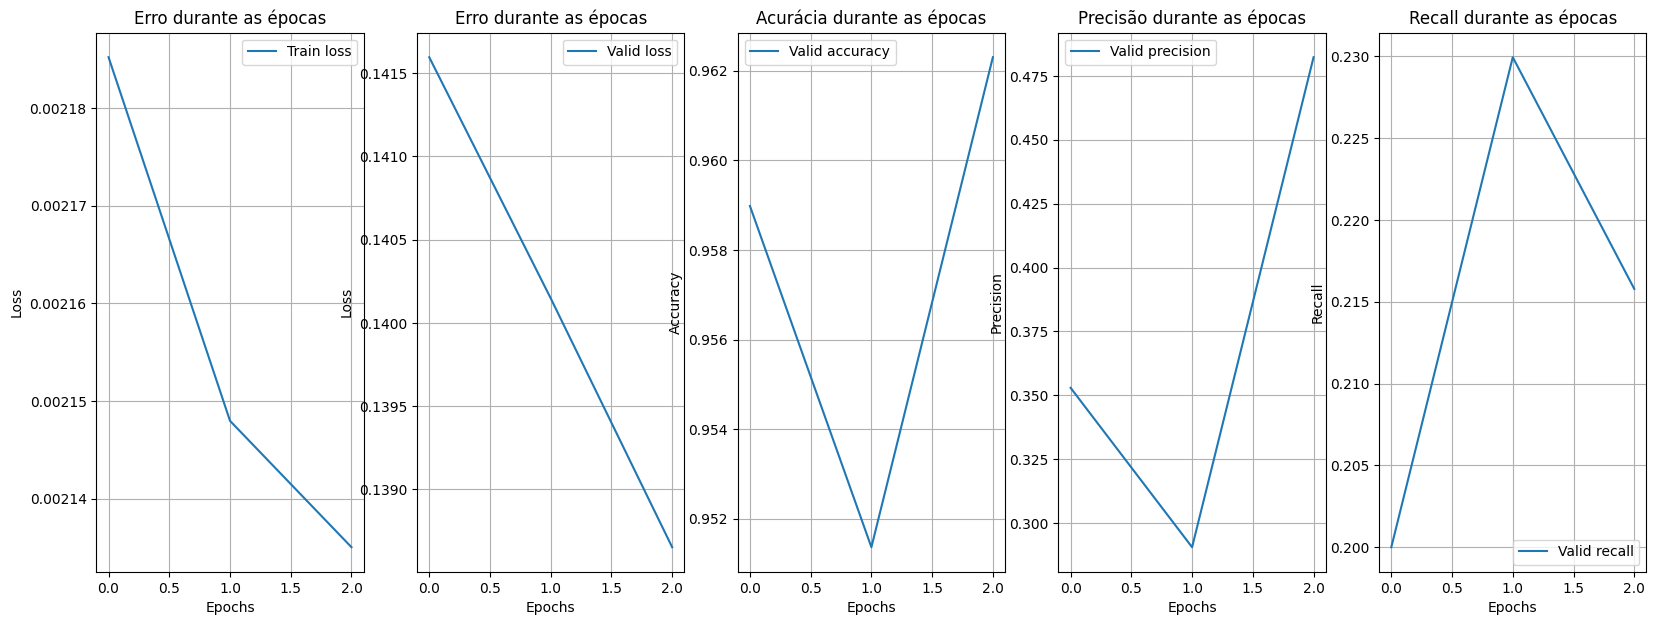

In [21]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 5, figsize=(20,7))

ax[0].plot(history_handcraft['train']['loss'], label='Train loss')
ax[1].plot(history_handcraft['valid']['loss'], label='Valid loss')
ax[2].plot(history_handcraft['valid']['acc'], label='Valid accuracy')
ax[3].plot(history_handcraft['valid']['precision'], label='Valid precision')
ax[4].plot(history_handcraft['valid']['recall'], label='Valid recall')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Erro durante as épocas')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Erro durante as épocas')
ax[1].legend()
ax[1].grid()

ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Acurácia durante as épocas')
ax[2].legend()
ax[2].grid()

ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Precision')
ax[3].set_title('Precisão durante as épocas')
ax[3].legend()
ax[3].grid()

ax[4].set_xlabel('Epochs')
ax[4].set_ylabel('Recall')
ax[4].set_title('Recall durante as épocas')
ax[4].legend()
ax[4].grid()

plt.show()

### Visualize model predictions

In [40]:
def show_prediction(model, dataloader, class_names):
  '''
  Show a sample prediction.

  Parameters:
  -----------
  model : nn.Module
    Model to be evaluated.

  dataloader : dataloader
    DataLoader for the example.

  class_names : list
    List containing the class names.

  '''
  data, target = next(iter(dataloader))
  data = data.to(device)
  logits = model(data.type(torch.float))

  thresh = ((np.sort(logits.detach().cpu().numpy()))[0])[::-1][10]

  top10 = np.array(logits.cpu() > thresh, dtype=float)
  top10   = '\n'.join(class_names[top10[0] == 1])
  print(f"Top 10 classes most likely to be in the photo (not in order):\n{top10}")

  pred   = np.array(logits.cpu() > .12, dtype=float)
  plt.imshow(data[0].cpu().permute(1,2,0))
  plt.axis('off')
  plt.show()

  target = ''.join(class_names[target[0] == 1])
  pred   = ''.join(class_names[pred[0] == 1])
  print(f"Target: {target}\nPred: {pred if len(pred) != 0 else 'NONE'}")

Top 10 classes most likely to be in the photo:
 backpack
 bottle
 bowl
 car
 chair
 clock
 cup
 diningtable
 person
 truck


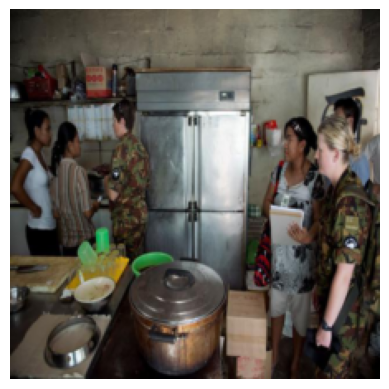

Target:  backpack book bowl cup diningtable handbag knife oven person refrigerator
Pred:  diningtable person


In [ ]:
model_v1 = HandcraftCNN_v1()
model_v1 = load_model("weights_handcraft.pth", model_v1)
model_v1.to(device).eval()

show_prediction(model_v1, valid_loader, class_names)

 > What are the conclusions? Was this model sufficient for the task? Do the hyperparameters, such as learning rate, batch size, and others, impact the final result? (1-2 paragraphs)

Os modelos desenvolvidos à mão não apresentaram um desempenho satisfatório, conforme pode ser observado pelas métricas apresentadas. Por exemplo, pelo valor do recall, conclui-se que o número de falsos positivos do modelo é maior do que o número de verdadeiros positivos. Por outro lado, a acurácia do modelo é consideravelmente alta, mas isso se deve ao fato de que ele acerta a maioria das classes que não estão na imagem. Isto é, o número de verdadeiros negativos foi alto (o que era esperado considerando o número de classes total do dataset).

Apesar de terem sido realizadas diversas alterações em hiperparâmetros não houve uma variação significativa na performance do modelo, o qual não se demonstrou suficientemente bom para a tarefa proposta. Por outro lado, ele apresentou um desempenho melhor do que o de um modelo aleatório, indicando que houve um "aprendizado" envolvido no processo de treinamento. Além disso, observa-se que o desbalanceamento do dataset teve grande influência nos resultados das predições, sendo que, por exemplo, a grande quantidade de imagens com label "person" fez com que sempre o modelo sempre achasse que tem uma pessoa na imagem, independente do seu conteúdo real.

### 2. (3 points) Apply the Transfer Learning Technique by utilizing one of the pre-trained CNN models available in PyTorch as backbone.

In [23]:
from torchvision.models import resnet50
## Loading a pre-trained convolutional model and fine-tuning it on the COCO dataset
# Link: https://pytorch.org/vision/stable/models.html

model_tf = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_tf.fc.in_features
for param in model_tf.parameters():
  param.requires_grad = False
model_tf.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=num_ftrs,
        out_features=80
    ) ,   torch.nn.Sigmoid()
)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [24]:
data, target = next(iter(train_loader))
logits = model_tf(data.type(torch.float))

assert logits.shape == (batch_size, len(class_names)), 'Output Shape incorrect'

In [25]:
criterion     = nn.BCELoss()
optimizer     = optim.SGD(model_tf.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model_tf.to(device)

best_loss = None
history   = {'train': {'loss': [], 'acc': []},
             'valid': {'loss': [], 'acc': [], 'precision': [], 'recall': []}}

for epoch in range(0, epochs):
  # --- Train Model --- #
  model_tf, history = train_one_epoch(model_tf, criterion, optimizer, history)

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    history, results = evaluate_one_epoch(model_tf, criterion, optimizer, history)

    # --- Save best model weights --- #
    best_loss = save_model(model_tf, best_loss, np.array(history['valid']['loss'])[-1].mean(), save_path='weights_ft_freeze.pth')

    print(f"Epoch: {epoch}\n\tAccuracy = {results['acc']}\tPrecision = {results['precision']}\tRecall = {results['recall']}")

Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 0
	Accuracy = 0.9556640625	Precision = 0.3743016759776536	Recall = 0.36813186813186816
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 1
	Accuracy = 0.9533203124999999	Precision = 0.4351851851851852	Recall = 0.44549763033175355
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 2
	Accuracy = 0.9484374999999999	Precision = 0.37130801687763715	Recall = 0.43349753694581283


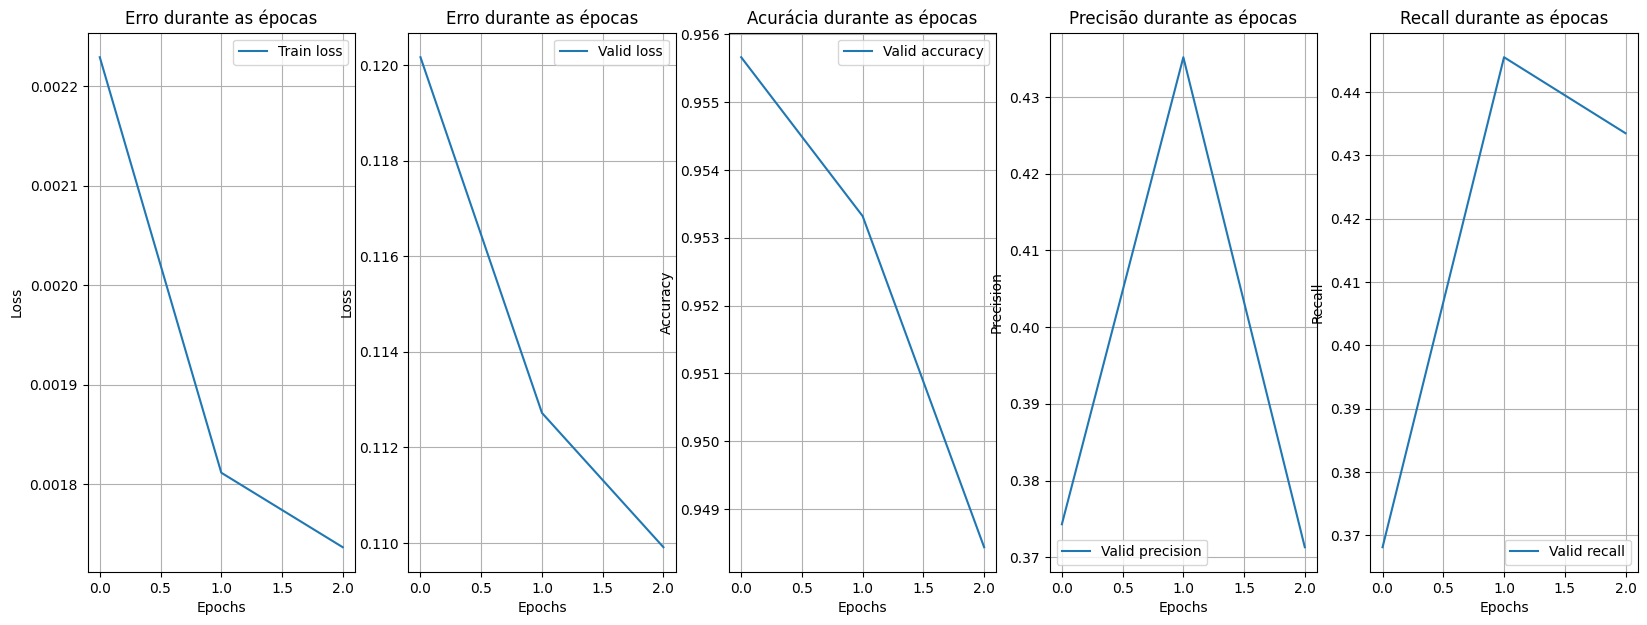

In [26]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 5, figsize=(20,7))

ax[0].plot(history['train']['loss'], label='Train loss')
ax[1].plot(history['valid']['loss'], label='Valid loss')
ax[2].plot(history['valid']['acc'], label='Valid accuracy')
ax[3].plot(history['valid']['precision'], label='Valid precision')
ax[4].plot(history['valid']['recall'], label='Valid recall')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Erro durante as épocas')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Erro durante as épocas')
ax[1].legend()
ax[1].grid()

ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Acurácia durante as épocas')
ax[2].legend()
ax[2].grid()

ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Precision')
ax[3].set_title('Precisão durante as épocas')
ax[3].legend()
ax[3].grid()

ax[4].set_xlabel('Epochs')
ax[4].set_ylabel('Recall')
ax[4].set_title('Recall durante as épocas')
ax[4].legend()
ax[4].grid()

plt.show()

### Visualize model predictions

Top 10 classes most likely to be in the photo:
 backpack
 bench
 boat
 car
 chair
 dog
 handbag
 person
 surfboard
 umbrella


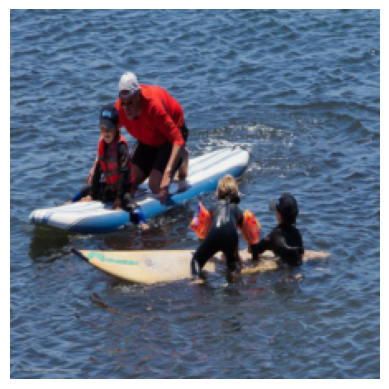

Target:  person surfboard
Pred:  boat person surfboard


In [ ]:
model_tf = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_tf.fc.in_features
model_tf.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=num_ftrs,
        out_features=80
    ) ,   torch.nn.Sigmoid()
)

model_tf = load_model("weights_ft_freeze.pth", model_tf)
model_tf.to(device).eval()

show_prediction(model_tf, valid_loader, class_names)

 > What are the conclusions? Does the performance improve? Is it better to freeze the entire model or update all the weights in this case? (1-2 paragraphs)

Após a realização do transfer learning, utilizando o modelo `resnet50` com os pesos obtidos do treinamento com o dataset `IMAGENET1K_V1` observou-se uma melhora considerável na performance do modelo, especialmente ao avaliar as métricas como precisão e recall. A melhora nessas métricas indica uma menor incidência de falsos negativos e falsos positivos, além de um aumento nos verdadeiros positivos.

Essa melhora de performance foi observada tanto para o caso em que os pesos foram congelados, quanto para o modelo em que os pesos foram todos atualizados. Porém, para o caso específico do treinamento executado, com os hiperparâmetros específicos (como número de épocas, batch size, etc) o modelo com congelamento demonstrou um melhor desempenho, mostrando que apenas um fine tuning dos pesos já traz uma melhora significativa, resultando num modelo eficiente, considerando sua complexidade não muito avançada. Uma característica interessante do modelo gerado é que ele acaba incluindo em suas predições elementos que são comuns no contexto da imagem apresentada mas que não estão de fato nela, por exemplo, predizendo que há barcos em imagens com mar, ou garfos e facas em imagens de cozinhas.

### 3. (3 points) Apply the Data Augmentation technique to either the handcrafted model or the transfer learning model.

*Tip: Be careful to choose appropriate transformations that do not destroy the information of the sample.*

In [29]:
## Data augmentation during training. Choose appropriate transformations.
# Link: https://pytorch.org/vision/stable/transforms.html

train_transforms = valid_transforms = Compose([
    Resize((112,112)),
    ColorJitter(hue=.05, saturation=.05),
    RandomHorizontalFlip(),
    RandomRotation(20),
    ToTensor()
])

train_dataset = COCOMulticlass('partial_dataset.csv', 'COCO-multiclass/train', transform=train_transforms)
valid_dataset = COCOMulticlass('COCO-multiclass/valid/_classes.csv', 'COCO-multiclass/valid', transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [30]:
model = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
for param in model_tf.parameters():
  param.requires_grad = False
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=num_ftrs,
        out_features=80
    ) ,   torch.nn.Sigmoid()
)

model = load_model("weights_ft_freeze.pth", model)

criterion     = nn.BCELoss()
optimizer     = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model.to(device)

best_loss = None
history_augm   = {'train': {'loss': [], 'acc': []},
             'valid': {'loss': [], 'acc': [], 'precision': [], 'recall': []}}

for epoch in range(0, epochs):
  # --- Train Model --- #
  model, history_augm = train_one_epoch(model, criterion, optimizer, history_augm)

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    history_augm, results = evaluate_one_epoch(model, criterion, optimizer, history_augm)

    # --- Save best model weights --- #
    best_loss = save_model(model, best_loss, np.array(history_augm['valid']['loss'])[-1].mean(), save_path='weights_ft_freeze_augm.pth')

    print(f"Epoch: {epoch}\n\tAccuracy = {results['acc']}\tPrecision = {results['precision']}\tRecall = {results['recall']}")

Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 0
	Accuracy = 0.940234375	Precision = 0.33432835820895523	Recall = 0.5743589743589743
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 1
	Accuracy = 0.916796875	Precision = 0.27655310621242485	Recall = 0.6798029556650246
Trained: 10000/30000
Trained: 20000/30000
Trained: 30000/30000
Epoch: 2
	Accuracy = 0.9232421875	Precision = 0.2621359223300971	Recall = 0.5482233502538071


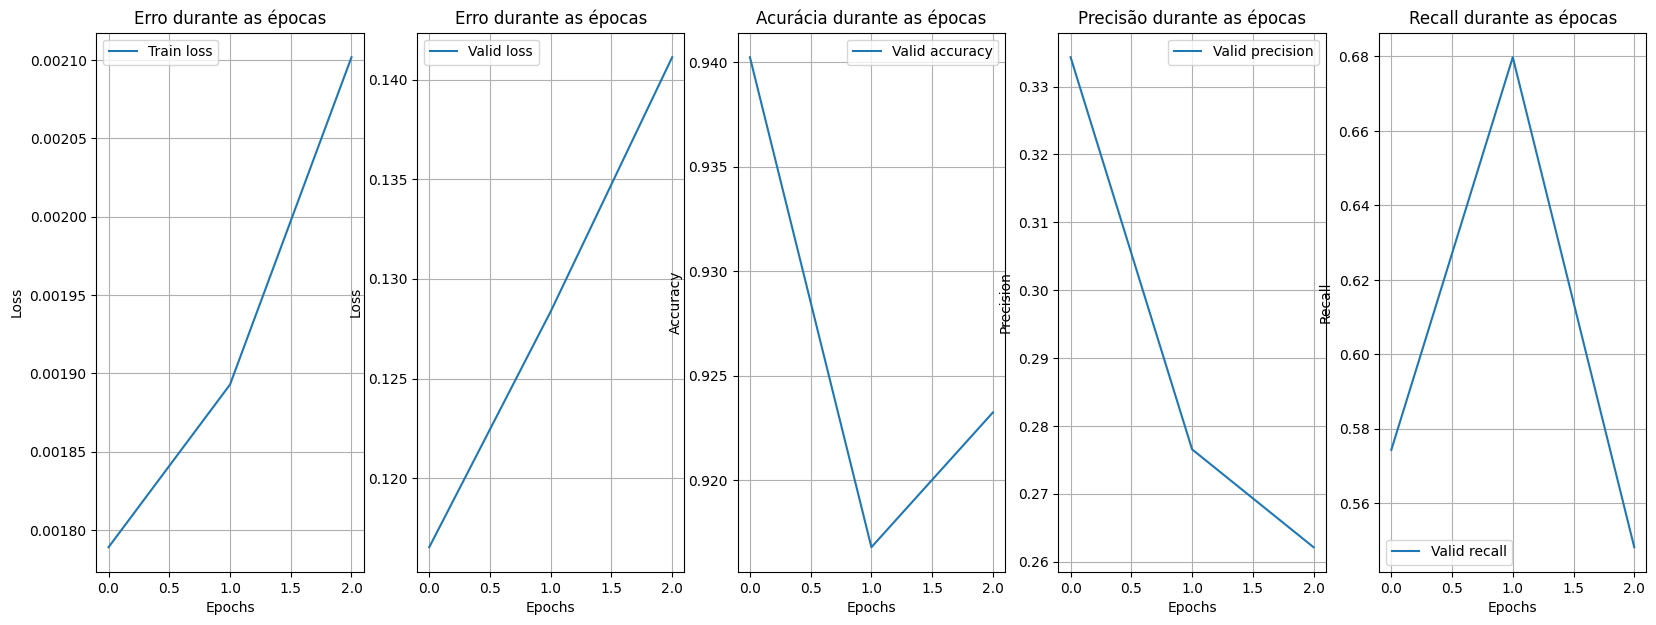

In [31]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 5, figsize=(20,7))

ax[0].plot(history_augm['train']['loss'], label='Train loss')
ax[1].plot(history_augm['valid']['loss'], label='Valid loss')
ax[2].plot(history_augm['valid']['acc'], label='Valid accuracy')
ax[3].plot(history_augm['valid']['precision'], label='Valid precision')
ax[4].plot(history_augm['valid']['recall'], label='Valid recall')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Erro durante as épocas')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Erro durante as épocas')
ax[1].legend()
ax[1].grid()

ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Acurácia durante as épocas')
ax[2].legend()
ax[2].grid()

ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Precision')
ax[3].set_title('Precisão durante as épocas')
ax[3].legend()
ax[3].grid()

ax[4].set_xlabel('Epochs')
ax[4].set_ylabel('Recall')
ax[4].set_title('Recall durante as épocas')
ax[4].legend()
ax[4].grid()

plt.show()

Top 10 classes most likely to be in the photo:
 book
 bottle
 bowl
 chair
 cup
 diningtable
 fork
 knife
 person
 spoon


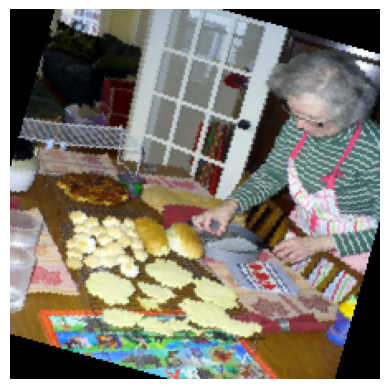

Target:  bird cake chair cup diningtable hot dog person sofa spoon
Pred:  book bottle bowl cake chair cup diningtable fork knife person pizza sink sofa spoon tvmonitor


In [ ]:
model_tf = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_tf.fc.in_features
model_tf.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=num_ftrs,
        out_features=80
    ) ,   torch.nn.Sigmoid()
)

model_tf = load_model("weights_ft_freeze_augm.pth", model_tf)
model_tf.to(device).eval()

show_prediction(model_tf, valid_loader, class_names)

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)

Embora o esperado fosse uma melhora no desempenho do modelo, constata-se que ele apresenta uma performance muito semelhante às dos modelos de transfer learning sem data augmentation. No caso, foram utilizadas transformações de rotações aleatórias, de 20 graus, "flips" horizontais das imagens, resizing e de leves alterações na coloração da imagem (ColorJitter). Com isso, houve um aumento do número de dados utilizados no treinamento, porém, devido talvez à complexidade limitada do modelo e dos passos de treinamento, não houve uma melhoria de performance, porém constata-se que, de maneira geral, o modelo passou a apresentar mais classes na predição final.

## Object Detection with COCO

Object detection is a fundamental computer vision task in deep learning that involves the identification and localization of objects within images or videos. It surpasses simple image classification, which only determines the presence or absence of specific objects in an image. Object detection algorithms not only recognize various objects but also provide valuable information about their locations using bounding box coordinates.

![object_example](https://drive.google.com/uc?export=view&id=1aFGdmMu4OzGfKjNjxdZXRu2wdz1JbJxC)


The goal of object detection is to accurately detect and classify multiple objects of different classes within an image. This task is challenging because objects can vary in size, shape, orientation, and occlusion. Additionally, there can be multiple instances of the same object class present in an image.

Deep learning-based object detection approaches typically involve training a neural network model to learn representations of objects. These models often use convolutional neural networks (CNNs) as the backbone architecture, which excel at learning hierarchical features from visual data. The most popular and effective deep learning models for object detection include Faster R-CNN, YOLO (You Only Look Once), and SSD (Single Shot MultiBox Detector).

![model_example](https://drive.google.com/uc?export=view&id=1Bov_GML9BfXoCtHzuQDYbiccj-3Ir0Mb)

During training, object detection models are typically trained on labeled datasets, where each annotated image contains bounding box annotations and corresponding class labels for the objects of interest. The models learn to predict the class labels and bounding box coordinates during the training process, optimizing their parameters through techniques like gradient descent and backpropagation.

In [ ]:
## ----- Global Variables ----- ##
batch_size      = None
learning_rate   = None
epochs          = None
evaluate_period = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

### Auxiliar functions

In [ ]:
def adjust_annotations(path, save_filename='_classes.csv'):
  '''
    Convert the json file to csv

    Parameters
    ----------
    path : str
      Path to the _annotations.coco.json file.

    save_filename : str
      Name of the file to be saved.
  '''

  data = json.load(open(path))

  df = open(save_filename, 'w')
  df.write('ImageID,Label,start_x,start_y,width,height,area,iscrowd\n')

  for a in data['annotations']:
    df.write(f"{a['image_id']},{a['category_id']},{a['bbox'][0]},{a['bbox'][1]},{a['bbox'][2]},{a['bbox'][3]},{a['area']},{a['iscrowd']}\n")

  df.close()

def get_partial_dataset(path, save_filename='partial_dataset', n_samples=30000):
  '''
    Creates a partial dataset for training

    Parameters
    ----------
    path : str
      Path to the _classes.csv file.

    save_filename : str
      Name of the file to be saved.

    n_samples : int
      Specifies the number of samples for training.
  '''

  df = pd.read_csv(path)

  idxs = df.ImageID.drop_duplicates()
  idxs = idxs.sample(idxs.shape[0] - n_samples).values.tolist()
  df = df.query('ImageID != @idxs').reset_index(drop=True)

  df.to_csv(f'{save_filename}.csv', index=False)

adjust_annotations('COCO-object-detection/train/_annotations.coco.json', '_classes_train.csv')
adjust_annotations('COCO-object-detection/valid/_annotations.coco.json', '_classes_valid.csv')
get_partial_dataset('_classes.csv')

### Class Dataset and DataLoader

*Obs: Learn more in [Dataset and Dataloader Tutorial Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)*

In [ ]:
class COCOObjectDetection(Dataset):
  '''
    Dataset class

    Parameters:
    -----------
    __init__():
      annotations_file : str
        Path to the _classes_train.csv file or partial_dataset.csv file

      img_idx_file : str
        Path to the _annotations.coco.json file.

      img_dir : str
        Path to the directory containing the images

      transform : torchvision.transforms
        Image transformations from the torchvision library.
  '''

  def __init__(self, annotations_file, img_idx_file, img_dir, transform=None):
    self.annotations = pd.read_csv(annotations_file)
    self.all_imgs    = self.annotations.ImageID.unique()
    self.img_dir     = img_dir
    self.img_id      = json.load(open(img_idx_file))['images']
    self.transform   = transform
    self.class_names = json.load(open(img_idx_file))['categories']

  def __len__(self):
    return len(self.all_imgs)

  def __getitem__(self, idx):
    image_id = int(self.all_imgs[idx])
    img_path = os.path.join(self.img_dir, self.img_id[image_id]['file_name'])
    image    = cv2.imread(img_path)
    image    = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_resized = cv2.resize(image, (224, 224))
    image_resized /= 255.0

    image_width = image.shape[1]
    image_height = image.shape[0]

    boxes  = []
    labels = []

    objects = self.annotations.query("ImageID == @image_id")
    for _, row in objects.iterrows():
      xmin = row.start_x
      xmax = xmin + row.width
      ymin = row.start_y
      ymax = ymin + row.height

      xmin = (xmin/image_width)*224
      xmax = (xmax/image_width)*224
      ymin = (ymin/image_height)*224
      ymax = (ymax/image_height)*224

      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(row.Label)

    boxes   = torch.as_tensor(boxes, dtype=torch.float32)
    area    = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels  = torch.as_tensor(labels).type(torch.int64)

    target = {}
    target["boxes"]    = boxes
    target["labels"]   = labels
    target["area"]     = area
    target["iscrowd"]  = iscrowd
    target["image_id"] = torch.Tensor([image_id])

    if self.transform:
      sample = self.transform(image = image_resized,
                                bboxes = target['boxes'],
                                labels = labels)
      image_resized = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
    return image_resized, target

In [ ]:
train_dataset = COCOObjectDetection('partial_dataset.csv', 'COCO-object-detection/train/_annotations.coco.json', 'COCO-object-detection/train/', transform=None)
data, target = train_dataset[5]
class_names = train_dataset.class_names

## --- Plot one sample --- ##
fig, ax = plt.subplots()
ax.imshow(data, cmap='binary', interpolation='nearest')
for box, label in zip(target['boxes'], target['labels']):
  rect = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.text(box[0], box[1], class_names[label]['name'], color='red')
  ax.add_patch(rect)
plt.axis('off')
plt.show()

### Train and Evaluate functions

In [ ]:
def train(model, dataloader, optimizer, device):
  '''
    Simple training function.

    Parameters:
    -----------
    model : nn.Module
      Model to be trained.

    dataloader : DataLoader
      Data to train the model.

    optimizer : torch.optim
      Optimizer for backpropagation.

    device : torch.device
      Device to run the training.
  '''

  model.train()
  for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=False, desc='Training'):
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

    # --- Insert Code Here --- #

  return None

def evaluate(model, dataloader, device):
  '''
    Simple evaluation function.

    Parameters:
    -----------
    model : nn.Module
      Model to be evaluated.

    dataloader : DataLoader
      Data for evaluation.

    device : torch.device
      Device to run the evaluation.
  '''
  model.eval()
  for inputs, labels in tqdm(dataloader, total=len(dataloader), leave=False, desc='Evaluating'):
    inputs = list(image.to(device) for image in inputs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

    # --- Insert Code Here --- #

  return None

def save_model(model, best_loss, current_loss):
  '''
    Save the best model weights.
    This function saves the weights locally.
    To prevent data loss, consider adding the Google Drive path in the `torch.save()` function.

    Parameters:
    -----------
    model : nn.Module
      Model to save the weights.

    best_loss : float
      Best loss achieved so far.

    current_loss : float
      Current loss to compare with the best loss.
  '''
  if best_loss == None:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  elif best_loss > current_loss:
    best_loss = current_loss
    torch.save(model.state_dict(), 'weights.pth')

  else: pass
  return best_loss

def load_model(path, model):
  '''
    Load the model weights.

    Parameters:
    -----------
    path : str
      Path to the .pth file containing the weights.

    model : nn.Module
      Model to load the weights into.
  '''
  model.load_state_dict(torch.load(path))
  return model

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
data_transform = A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
train_dataset = COCOObjectDetection('partial_dataset.csv', 'COCO-object-detection/train/_annotations.coco.json', 'COCO-object-detection/train/', transform=data_transform)
valid_dataset = COCOObjectDetection('_classes_valid.csv',  'COCO-object-detection/valid/_annotations.coco.json', 'COCO-object-detection/valid/', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

### 4. (1 points) Apply the transfer learning technique by utilizing one of the pre-trained object detection models available in PyTorch as a backbone.

In [ ]:
## TODO: Load a pre-trained convolutional model and fine-tune it on the COCO dataset
# Link: https://pytorch.org/vision/0.8/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Insert Code Here --- #
    def forward(self, x):
        # --- Insert Code Here --- #
        return None

model_od = ObjectDetectionModel()

In [ ]:
optimizer     = None  # Choose an appropriate optimizer in https://pytorch.org/docs/stable/optim.html

model.to(device)

best_loss = None

for epoch in range(0, epochs):
  # --- Train Model --- #
  train()

  # --- Evaluate model in N epochs --- #
  if (epoch % evaluate_period) == 0:
    evaluate()

    # --- Save best model weights --- #
    best_loss = save_model(model, best_loss, np.array(history['valid'])[-1].mean())

In [ ]:
## ----- Plot the Train and Valid loss ----- ##
fig, ax = plt.subplots(1, 4, figsize=(20,7))
plt.show()

### Visualize model predictions

In [ ]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))
model = ObjectDetectionModel()
model.load_model()
model.to(device).eval()

path = 'COCO-object-detection/valid/'
test_images = glob.glob(f"{path}/*.jpg")

# --- Threshold --- #
# Any detection having score below this will be discarded
# Choose between 0 and 1
detection_threshold = None

In [ ]:
def plot_prediction(model, idx, class_names=class_names):
  '''
    Plot one sample

    Parameters
    ----------

    model : nn.Module
      The model to be evaluated.

    idx : int
      The index of the desired image.

    class_names : list
      A list of class names.
  '''

  image_name = test_images[idx].split(os.path.sep)[-1].split('.')[0]
  image = cv2.imread(test_images[idx])
  orig_image = image.copy()
  image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  image = np.transpose(image, (2, 0, 1)).astype(np.float32)
  image = torch.tensor(image, dtype=torch.float)
  image = torch.unsqueeze(image, 0)

  with torch.no_grad():
    outputs = model(image.to(device))

  outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

  if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()

    pred_classes = [class_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    fig, ax = plt.subplots()
    ax.imshow(image.cpu()[0].permute(1,2,0), cmap='binary', interpolation='nearest')
    for j, box in enumerate(draw_boxes):
      class_name = pred_classes[j]['name']
      rect = patches.Rectangle((box[0], box[1]), box[2]-box[0],box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
      ax.text(box[0], box[1], class_name, color='red')
      ax.add_patch(rect)
    plt.axis('off')
    plt.show()

In [ ]:
plot_prediction(model, 50)

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)